# Lung fibrosis v5 - ResNet34 - Grad-CAM

This notebook uses the [dataset](https://osf.io/28qbc/) from the publication "[Deep neural network based histological scoring of lung fibrosis and inflammation in the mouse model system](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202708)" to train an CNN based on a ResNet34 to characterize lung fibrosis from sections of lung tissue.<br><br>
Grad-CAM visualization based on https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam.ipynb.

## Notebook setup

In [1]:
## notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai import *
from fastai.vision import *
import scipy.ndimage

In [3]:
# set path
path = Path('/home/paperspace/fastai/data/lung'); path

PosixPath('/home/paperspace/fastai/data/lung')

## Grad-CAM setup

### Data setup

In [4]:
# set batchsize and image size for network
bs = 64
size = 224

In [5]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.2, max_warp=0.2)

In [6]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_fibrosis', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets() # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [7]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

In [8]:
# print class names, number of class, length of train dataset, and length of valid dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '3', 'ignore', '5', '7', '1'], 6, 12037, 2139)

### Model setup

A ResNet34 is setup with pretrained weights from Imagenet with a custom head, i.e. the final layers specific for ImageNet classification are removed and replaced by final layers suitable for our 5 classes.

In [9]:
!gpustat --no-header

[0] Quadro P4000     | 34'C,   0 % |    10 /  8119 MB |


In [10]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [11]:
learn.load('lung_fib_v4-ResNet34_stage-2_train-3_epoch-2_0-803179');

In [12]:
!gpustat --no-header

[0] Quadro P4000     | 35'C,  12 % |   633 /  8119 MB | paperspace(623M)


### Hook setup

In [13]:
# define target layer for Grad-CAM
target_layer = learn.model[0][7][2]; target_layer

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [14]:
class Hook():
    "Create a hook."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        if not self.removed:
            self.hook.remove()
            self.removed=True

class Hooks():
    "Create several hooks."
    def __init__(self, ms:Collection[nn.Module], hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hooks = [Hook(m, hook_func, is_forward, detach) for m in ms]

    def __getitem__(self,i:int) -> Hook: return self.hooks[i]
    def __len__(self) -> int: return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    @property
    def stored(self): return [o.stored for o in self]

    def remove(self):
        for h in self.hooks: h.remove()

def hook_output (module:nn.Module) -> Hook:  return Hook (module,  lambda m,i,o: o)
def hook_outputs(modules:Collection[nn.Module]) -> Hooks: return Hooks(modules, lambda m,i,o: o)

class HookCallback(LearnerCallback):
    "Callback that registers given hooks."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if hasattr(m, 'weight')]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        if self.do_remove: self.remove()

    def remove(self): self.hooks.remove()
    def __del__(self): self.remove()

In [15]:
fmap_hook = hook_output(target_layer)

In [16]:
def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

In [17]:
gradient_hook = Hook(target_layer, gradient_torch_hook, is_forward=False)

## Grad-CAM visualization

In [18]:
img_batch, lbl_batch = next(iter(learn.data.train_dl))

In [19]:
def tensor2img(imgtensor):
    img = imgtensor.squeeze()
    img = img.cpu().numpy()
    img = np.moveaxis(img, 0, -1)
    img = img - img.min()
    img = img/img.max()
    return img

In [20]:
def multi_grad_cam(nrows=6, ncols=6, offset=0, figsize=(12,12)):
    
    # setup subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    # loop through images and subplots
    for i, ax in enumerate(axes.flat):
        
        # get image and label from image batch
        img = img_batch[i].reshape(1, 3, 224, 224) # reshape for model
        lbl = lbl_batch[i]
        
        # run image through model
        learn.model.eval() # set model in evaluation mode
        out = learn.model(img)
        
        # get gradients for predicted class
        onehot = torch.zeros(data.c) # setup empty tensor based on number of classes
        onehot[torch.argmax(out)] = 1. # one-hot-encode predicted class
        out.backward(gradient=onehot.reshape(1, -1).cuda()) # backpropagate onehot encoding to get gradients
        gradients = next(iter(gradient_hook.stored))
        
        # calculate grad-CAM
        gradient_linearization = gradients.cpu().numpy().sum((2,3)).reshape(-1) # sum up gradients and linearize
        fmaps = fmap_hook.stored.cpu().numpy().reshape(512, 7, 7) # reshape activations
        heatmap = np.maximum(0, np.einsum('i, ijk', gradient_linearization, fmaps)) # multiply summed gradients with the gradients to get the heatmap
        
        # prepare heatmap
        upsampled = scipy.ndimage.zoom(heatmap, 32) # upsample heatmap: 224/7 = 32
        
        # plotting
        ax.imshow(tensor2img(img))
        ax.imshow(upsampled, alpha=.75, cmap='hot')
        ax.set_title(data.classes[lbl.cpu().numpy()])
        ax.set_axis_off()

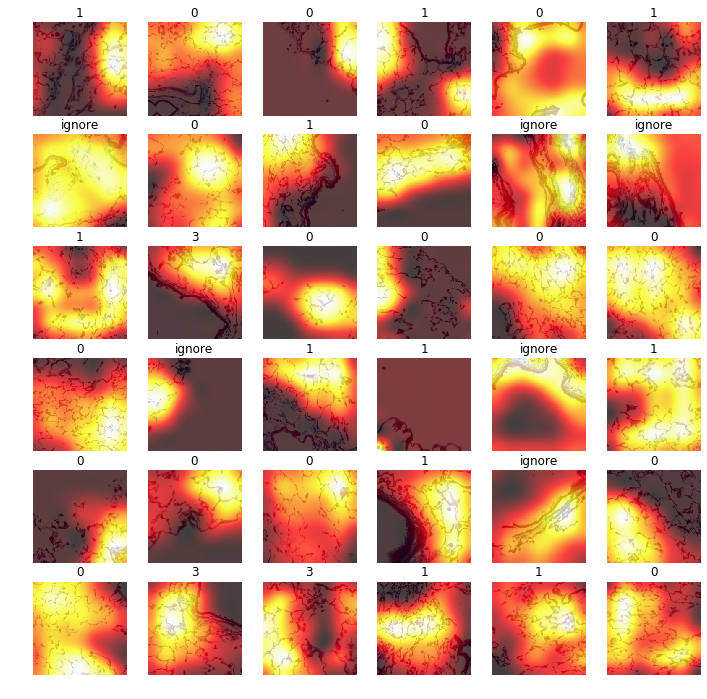

In [21]:
multi_grad_cam(offset=200)